In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.33 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
file_names = [data_dir + file_name for file_name in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples))

180040


In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

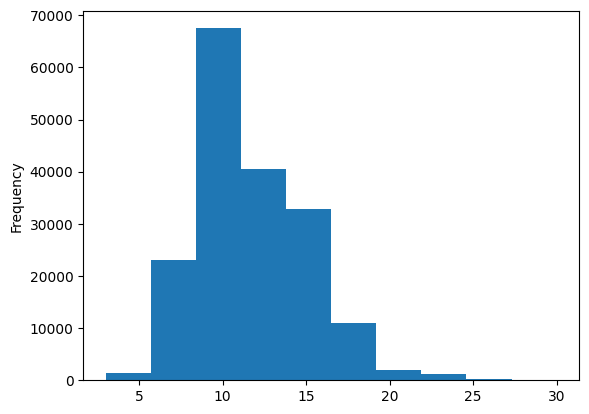

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([('Tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
                    ])

model_0.fit(
    X = train_sentences,
    y = train_labels_encoded
)

Pipeline(steps=[('Tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-01 18:16:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-01 18:16:34 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

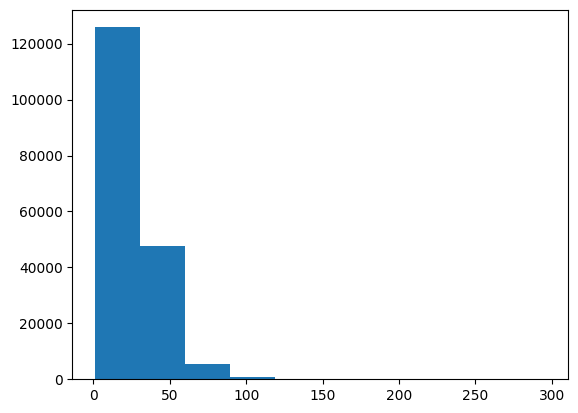

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins = 10);

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max_tokens = 68000

text_vectorizer = layers.TextVectorization(max_tokens = max_tokens,
                                           output_sequence_length=55,
                                           pad_to_max_tokens = True)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random

random_sentence = random.choice(train_sentences)
text_vectorizer([random_sentence]), random_sentence

(<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[ 1815,   613,    97,   897,     5,  1684, 30239,     9,    92,
           123,     6,   414,     6, 25842,   109,   307,  1345,    88,
             4,   566,  1951,   866,  6283,    11,  1183, 15525,  9940,
          6252,   661,  9063,  3347, 20904, 10063, 10027,  2575,  5488,
          8928, 11607, 30067,    16,  2575, 22545, 57630,   231,  1237,
          4682,     3,  4194,  2838, 25915,     0,     0,     0,     0,
             0]])>,
 'twelve community health centers in rural mali were randomly assigned to provide to @ mam children aged @-@ mo one of @ dietary supplements containing @ kcal/d for @ wk : @ ) ready-to-use , lipid-based supplementary food ( rusf ) ; @ ) special corn-soy blend ( csb + + ) ; @ ) locally processed , fortified flour ( misola ) ; or @ ) locally milled flours plus oil , sugar , and micronutrient powder ( lmf ) .')

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
rct_20k_text_vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [ ]:
token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name = 'token_embedding'
)

In [ ]:
print(random_sentence)
print(text_vectorizer([random_sentence]))
print(token_embed(text_vectorizer([random_sentence])))
print(token_embed(text_vectorizer([random_sentence])).shape)

twelve community health centers in rural mali were randomly assigned to provide to @ mam children aged @-@ mo one of @ dietary supplements containing @ kcal/d for @ wk : @ ) ready-to-use , lipid-based supplementary food ( rusf ) ; @ ) special corn-soy blend ( csb + + ) ; @ ) locally processed , fortified flour ( misola ) ; or @ ) locally milled flours plus oil , sugar , and micronutrient powder ( lmf ) .
tf.Tensor(
[[ 1815   613    97   897     5  1684 30239     9    92   123     6   414
      6 25842   109   307  1345    88     4   566  1951   866  6283    11
   1183 15525  9940  6252   661  9063  3347 20904 10063 10027  2575  5488
   8928 11607 30067    16  2575 22545 57630   231  1237  4682     3  4194
   2838 25915     0     0     0     0     0]], shape=(1, 55), dtype=int64)
tf.Tensor(
[[[-0.00707566  0.0158713   0.02404049 ... -0.02287595 -0.04529654
   -0.01877542]
  [ 0.04540446 -0.03306194 -0.04894772 ...  0.02105479  0.04337298
    0.02448631]
  [ 0.04936384 -0.02134254  0.023

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
inputs = layers.Input(shape = (1,), dtype = tf.string)

x = text_vectorizer(inputs)
x = token_embed(x)
x = tf.keras.layers.Conv1D(64, 5, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs)


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy() ,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch = int(0.1 * len(train_dataset)),
    epochs = 3,
    validation_data = val_dataset,
    validation_steps = int(0.1 * len(val_dataset))
)

Epoch 1/3
562/562 [==============================] - 44s 59ms/step - loss: 0.9232 - accuracy: 0.6325 - val_loss: 0.6949 - val_accuracy: 0.7274
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6646 - accuracy: 0.7532 - val_loss: 0.6408 - val_accuracy: 0.7626
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6217 - accuracy: 0.7730 - val_loss: 0.6007 - val_accuracy: 0.7836


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6008 - accuracy: 0.7843


[0.6008078455924988, 0.7842578887939453]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.3503010e-01, 2.0234492e-01, 5.0303690e-02, 2.9259497e-01,
        1.9726329e-02],
       [4.0157405e-01, 3.4888360e-01, 1.1058375e-02, 2.2744940e-01,
        1.1034606e-02],
       [1.6035672e-01, 4.9949931e-03, 1.8995269e-03, 8.3272803e-01,
        2.0724638e-05],
       ...,
       [6.5613190e-06, 9.8503684e-04, 9.5818850e-04, 4.5886754e-06,
        9.9804556e-01],
       [4.8670202e-02, 5.2114868e-01, 6.2831543e-02, 6.1924774e-02,
        3.0542484e-01],
       [2.3158459e-01, 5.9706646e-01, 5.2891556e-02, 5.8224380e-02,
        6.0233004e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

model_1_results

{'accuracy': 78.42579107639348,
 'precision': 0.7811214647692167,
 'recall': 0.7842579107639348,
 'f1': 0.7817172687285237}

In [ ]:
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False, name='USE'
)


In [ ]:
inputs = tf.keras.layers.Input(shape = [], dtype = tf.string)

use = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation = 'relu')(use)
outputs = layers.Dense(5, activation = 'softmax')(x)

model_2 = tf.keras.models.Model(inputs, outputs)

In [ ]:
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch = int(0.1 * len(train_dataset)),
    validation_data = val_dataset,
    validation_steps = int(0.1 * len(val_dataset)),
    epochs = 3
)

Epoch 1/3
562/562 [==============================] - 12s 13ms/step - loss: 0.9215 - accuracy: 0.6479 - val_loss: 0.7987 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7698 - accuracy: 0.7023 - val_loss: 0.7567 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7539 - accuracy: 0.7128 - val_loss: 0.7406 - val_accuracy: 0.7138


In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7419 - accuracy: 0.7144


[0.741885244846344, 0.7144181132316589]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.2969060e-01, 3.8579604e-01, 2.5844849e-03, 1.7271563e-01,
        9.2133051e-03],
       [3.4682620e-01, 5.0348699e-01, 3.9912066e-03, 1.4199892e-01,
        3.6966244e-03],
       [2.2363280e-01, 1.4660884e-01, 1.7406151e-02, 5.7275540e-01,
        3.9596815e-02],
       ...,
       [1.6486400e-03, 5.4737004e-03, 3.9243639e-02, 8.0643961e-04,
        9.5282757e-01],
       [3.8616208e-03, 4.8738126e-02, 2.1679939e-01, 1.4078977e-03,
        7.2919297e-01],
       [1.4623472e-01, 2.3804370e-01, 5.1726675e-01, 9.1448352e-03,
        8.9310028e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.44181120084735,
 'precision': 0.7145453635159619,
 'recall': 0.7144181120084735,
 'f1': 0.7115108307862048}

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

split_chars(random_sentence)

't w e l v e   c o m m u n i t y   h e a l t h   c e n t e r s   i n   r u r a l   m a l i   w e r e   r a n d o m l y   a s s i g n e d   t o   p r o v i d e   t o   @   m a m   c h i l d r e n   a g e d   @ - @   m o   o n e   o f   @   d i e t a r y   s u p p l e m e n t s   c o n t a i n i n g   @   k c a l / d   f o r   @   w k   :   @   )   r e a d y - t o - u s e   ,   l i p i d - b a s e d   s u p p l e m e n t a r y   f o o d   (   r u s f   )   ;   @   )   s p e c i a l   c o r n - s o y   b l e n d   (   c s b   +   +   )   ;   @   )   l o c a l l y   p r o c e s s e d   ,   f o r t i f i e d   f l o u r   (   m i s o l a   )   ;   o r   @   )   l o c a l l y   m i l l e d   f l o u r s   p l u s   o i l   ,   s u g a r   ,   a n d   m i c r o n u t r i e n t   p o w d e r   (   l m f   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

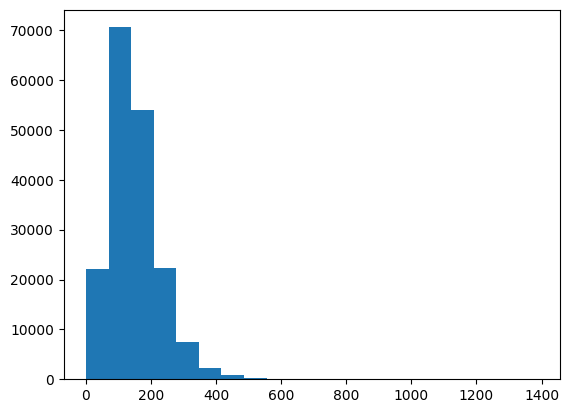

In [ ]:
import matplotlib.pyplot as plt

plt.hist(char_lens, bins = 20);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from keras.layers import TextVectorization
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

char_vocab, len(char_vocab)

(['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'],
 28)

In [ ]:
random_train_chars = random.choice(train_chars)
char_vectorizer([random_train_chars])

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[ 3,  7,  2, 21,  5, 12, 16,  5,  3,  2,  3, 13,  2,  2, 17, 17,
         2, 11,  3,  4, 21,  2,  6,  2,  9,  9,  7, 17,  3,  8,  5,  6,
         9, 11,  8,  5,  6,  4,  5, 12, 10,  4,  8,  2, 11,  3, 11, 16,
         8,  8,  2,  6,  3,  9,  3,  4, 15, 16, 12,  5,  3,  4,  7,  6,
         5, 12,  7,  6,  2,  5,  6, 10,  4,  6, 11,  7, 15, 22,  4,  6,
         5,  3,  4,  7,  6, 20,  4,  3, 13, 11,  7, 18,  6,  4,  3,  4,
        21,  2, 22,  2, 13,  5, 21,  4,  7, 16,  8,  5, 12, 15,  5,  6,
         5, 18,  2, 15,  2,  6,  3,  4,  6, 14,  5,  3,  4,  2,  6,  3,
         9, 20,  4,  3, 13,  6,  7,  6,  9, 14,  2, 11,  4, 17,  4, 11,
        11, 13,  8,  7,  6,  4, 11, 12,  7, 20, 22,  5, 11, 23, 14,  5,
         4,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [ ]:
char_embed = layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    mask_zero = True,
    name = 'char_embed'
)

In [ ]:
inputs = layers.Input(shape = (1, ), dtype = tf.string)

x = char_vectorizer(inputs)
x = char_embed(x)

x = layers.Conv1D(64, kernel_size = 20, padding = 'same', activation = 'relu')(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
x = layers.Conv1D(16, kernel_size = 20, padding = 'same', activation = 'relu')(x)
x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name = 'model_3_conv1d_char_embedding')



model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           32064     
                                                                 
 bidirectional (Bidirectiona  (None, 290, 128)         66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 2

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                steps_per_epoch = int(0.1 * len(train_char_dataset)),
                epochs = 3,
                validation_data = val_char_dataset,
                validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 35s 45ms/step - loss: 1.3878 - accuracy: 0.3796 - val_loss: 1.2032 - val_accuracy: 0.4777
Epoch 2/3
562/562 [==============================] - 23s 40ms/step - loss: 1.0946 - accuracy: 0.5478 - val_loss: 0.9198 - val_accuracy: 0.6336
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9371 - accuracy: 0.6233 - val_loss: 0.8600 - val_accuracy: 0.6612


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 17s 17ms/step


array([[2.7479190e-01, 4.3195790e-01, 4.8652716e-02, 1.7823897e-01,
        6.6358484e-02],
       [2.2994255e-01, 6.2410183e-02, 1.2127686e-02, 6.9082534e-01,
        4.6942732e-03],
       [2.1884611e-01, 9.7828836e-04, 1.9114880e-03, 7.7815974e-01,
        1.0439336e-04],
       ...,
       [1.8052958e-02, 1.2263084e-01, 1.4101602e-01, 1.9236043e-02,
        6.9906414e-01],
       [4.2867236e-02, 3.5267520e-01, 1.4171870e-01, 4.3330960e-02,
        4.1940793e-01],
       [3.6917713e-01, 3.6500102e-01, 4.5817591e-02, 1.9366097e-01,
        2.6343280e-02]], dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)

model_3_results

{'accuracy': 64.93446312723421,
 'precision': 0.664703015284155,
 'recall': 0.6493446312723421,
 'f1': 0.6473580635861967}

In [ ]:
#Token level embedding
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embedding = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embedding)
token_model = tf.keras.models.Model(token_inputs, token_outputs)

#Character level embedding
char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)


#Concatenate these two outputs
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output, char_model.output])


#output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)


#construc model
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embedding')

In [ ]:
token_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_4')>

In [ ]:
token_model.input

<KerasTensor: shape=(None,) dtype=string (created by layer 'token_input')>

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['

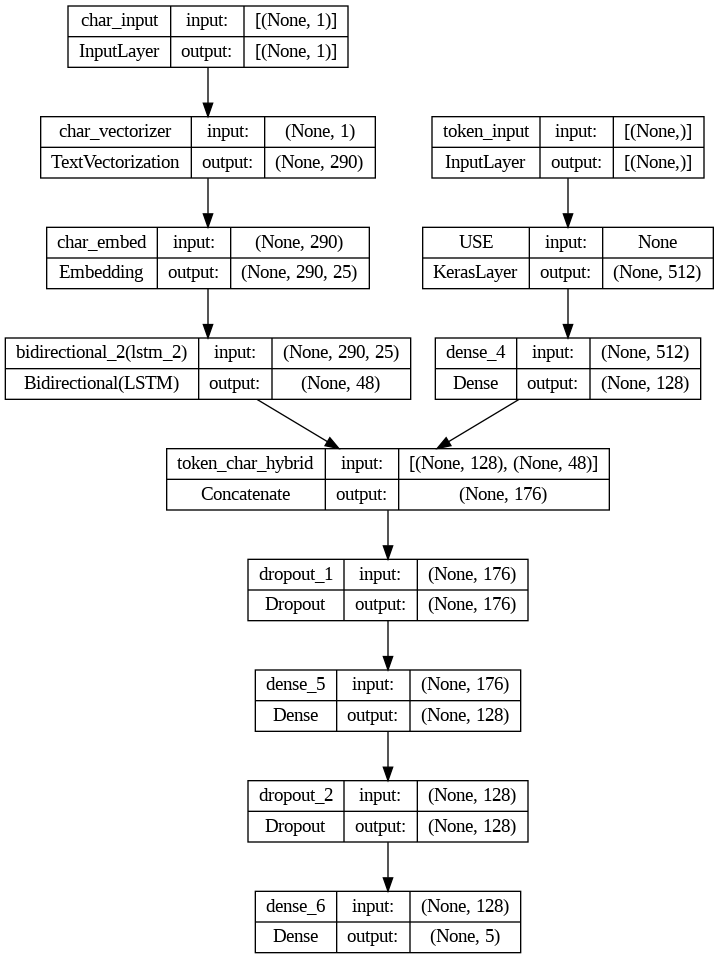

In [ ]:
from keras.utils import plot_model

plot_model(model_4, show_shapes = True)

In [ ]:
model_4.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))


train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 54ms/step - loss: 0.9756 - accuracy: 0.6108 - val_loss: 0.7751 - val_accuracy: 0.7058
Epoch 2/3
562/562 [==============================] - 30s 54ms/step - loss: 0.8037 - accuracy: 0.6904 - val_loss: 0.7205 - val_accuracy: 0.7197
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7768 - accuracy: 0.7023 - val_loss: 0.7001 - val_accuracy: 0.7311


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6999 - accuracy: 0.7327


[0.6998752951622009, 0.7326890230178833]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

945/945 [==============================] - 21s 19ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)

model_4_results

{'accuracy': 73.26889977492387,
 'precision': 0.7338351884234856,
 'recall': 0.7326889977492387,
 'f1': 0.7297770069423314}

In [ ]:
model_1_results

{'accuracy': 78.42579107639348,
 'precision': 0.7811214647692167,
 'recall': 0.7842579107639348,
 'f1': 0.7817172687285237}

In [ ]:
model_2_results

{'accuracy': 71.44181120084735,
 'precision': 0.7145453635159619,
 'recall': 0.7144181120084735,
 'f1': 0.7115108307862048}

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
np.percentile(train_df.line_number, 95)

13.0

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_onee_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

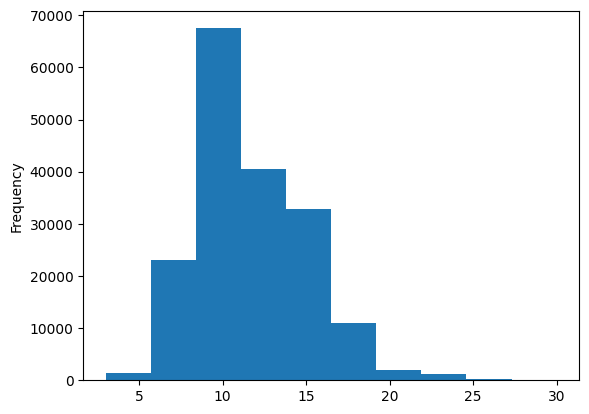

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 95)

18.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 15)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 15)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 15)

In [ ]:
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_inputs')
token_embedding = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embedding)

token_model = tf.keras.Model(token_inputs, token_outputs)



char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)

In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot.dtype

(TensorShape([180040, 15]), tf.float32)

In [ ]:
line_number_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_numbers_input')
line_number_outputs = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)



total_lines_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = 'total_lines_input')
total_lines_outputs = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

In [ ]:
combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [ ]:
tribrid_embeddings = layers.Concatenate(name = 'char_token_positional_embeddings')([line_number_model.output,
                                                                                    total_lines_model.output,
                                                                                    z])


output_layer = layers.Dense(5, activation = 'softmax', name= 'output_layers')(tribrid_embeddings)

In [ ]:
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                          total_lines_model.input,
                          token_model.input,
                          char_model.input],
                         outputs = output_layer,
                         name = 'model_5_tribrid_embedding_layer')

In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding_layer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['t

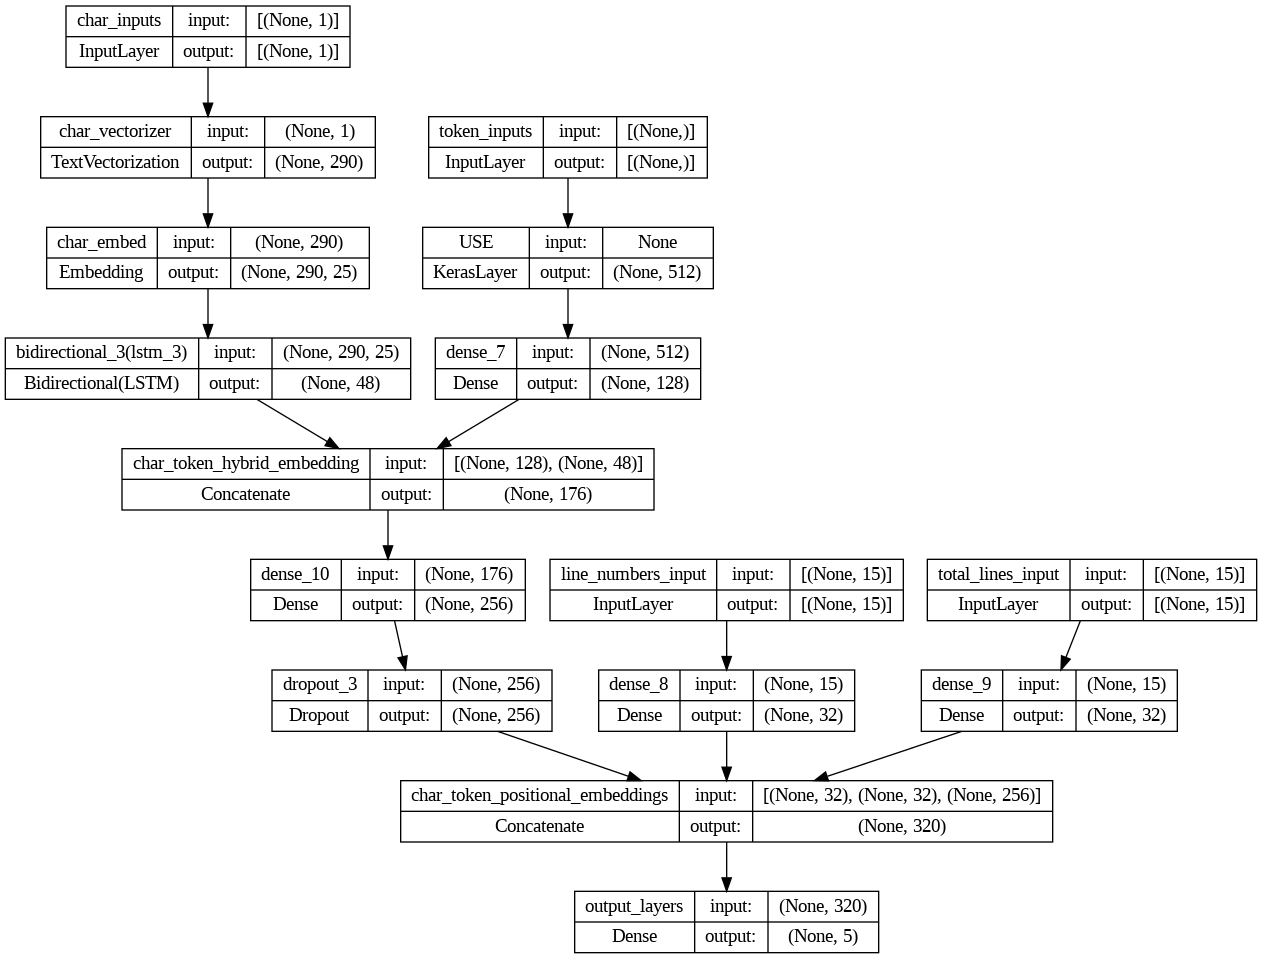

In [ ]:
plot_model(model_5, show_shapes = True)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 55ms/step - loss: 1.0906 - accuracy: 0.7259 - val_loss: 0.9789 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9650 - accuracy: 0.8163 - val_loss: 0.9482 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9484 - accuracy: 0.8240 - val_loss: 0.9377 - val_accuracy: 0.8351


In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.9357 - accuracy: 0.8338


[0.9356520771980286, 0.8338077664375305]

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

945/945 [==============================] - 23s 20ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.38077585065537,
 'precision': 0.8330714589873988,
 'recall': 0.8338077585065536,
 'f1': 0.8330472041750477}

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.425791,0.781121,0.784258,0.781717
model_2_pretrained_token_embedding,71.441811,0.714545,0.714418,0.711511
model_3_custom_char_embedding,64.934463,0.664703,0.649345,0.647358
model_4_hybrid_char_token_embedding,73.268900,0.733835,0.732689,0.729777
model_5_pos_char_token_embedding,83.380776,0.833071,0.833808,0.833047


In [ ]:
token_inputs = layers.Input(shape = (1,), dtype = tf.string)

x = text_vectorizer(token_inputs)
x = token_embed(x)
x = tf.keras.layers.Conv1D(64, 5, padding = 'same', activation = 'relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
token_outputs = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)

token_model = tf.keras.Model(token_inputs, token_outputs)



char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs, char_bi_lstm)


line_number_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_numbers_input')
line_number_outputs = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)



total_lines_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = 'total_lines_input')
total_lines_outputs = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)


combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)



tribrid_embeddings = layers.Concatenate(name = 'char_token_positional_embeddings')([line_number_model.output,
                                                                                    total_lines_model.output,
                                                                                    z])


output_layer = layers.Dense(5, activation = 'softmax', name= 'output_layers')(tribrid_embeddings)

In [ ]:
model_6 = tf.keras.Model(inputs = [line_number_model.input,
                          total_lines_model.input,
                          token_model.input,
                          char_model.input],
                         outputs = output_layer,
                         name = 'model_5_tribrid_embedding_layer')

In [ ]:
model_6.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 84s 130ms/step - loss: 1.0853 - accuracy: 0.7161 - val_loss: 0.9411 - val_accuracy: 0.8215
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.8995 - accuracy: 0.8556 - val_loss: 0.9318 - val_accuracy: 0.8138
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.8867 - accuracy: 0.8621 - val_loss: 0.9169 - val_accuracy: 0.8281


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

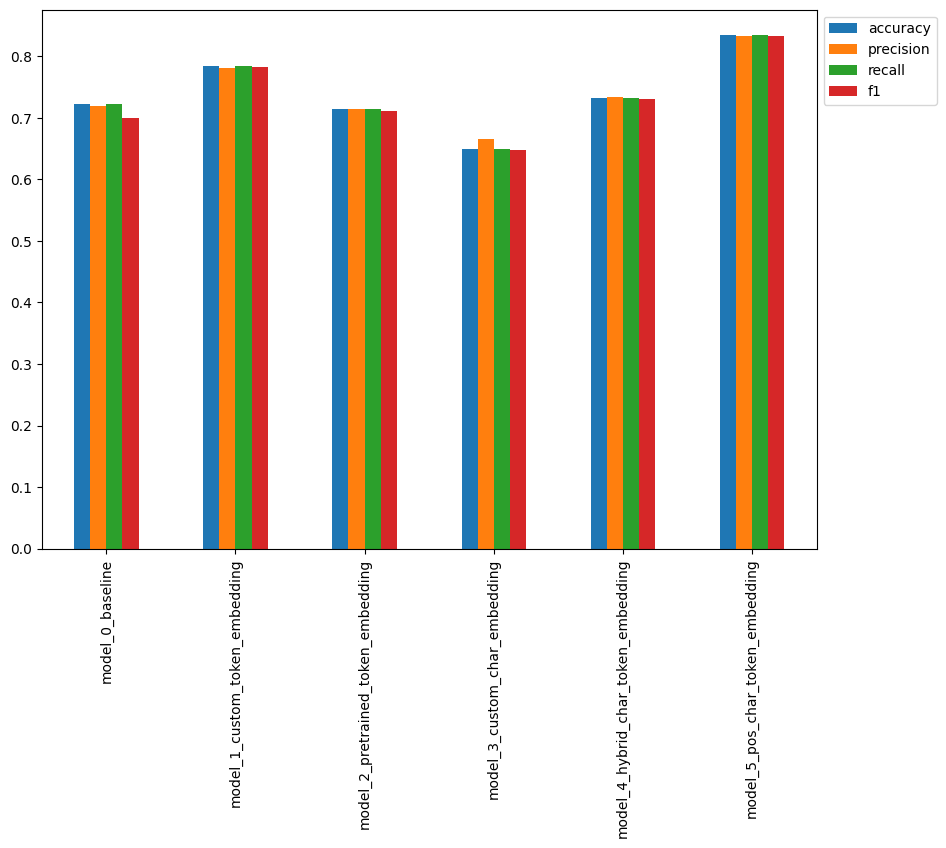

In [ ]:
all_model_results.plot(kind = 'bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0))

<Axes: >

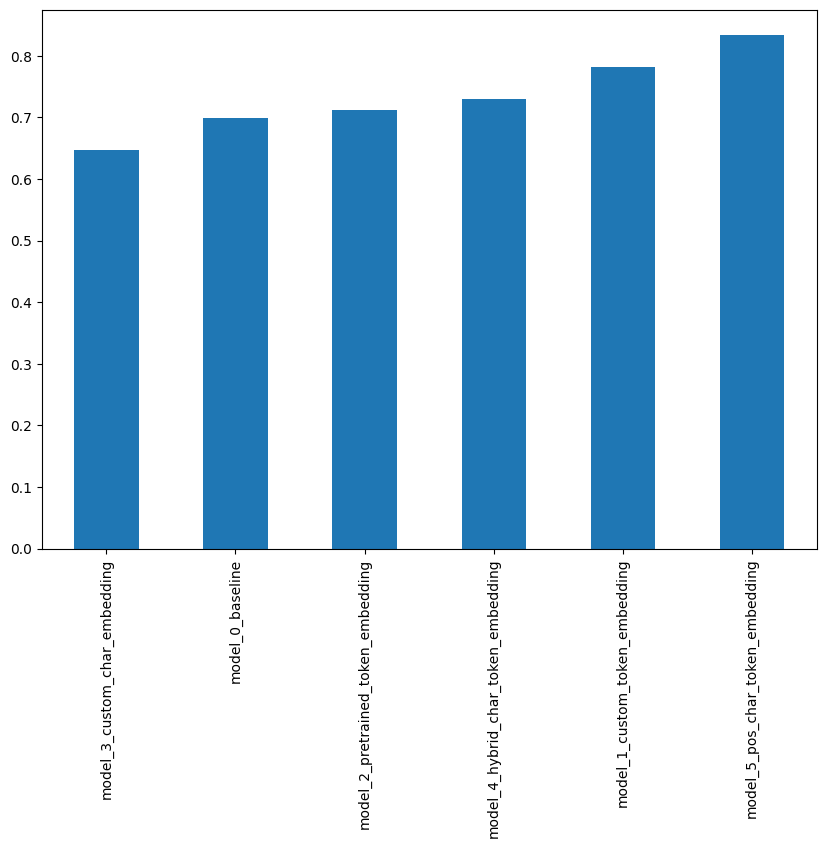

In [ ]:
all_model_results.sort_values('f1', ascending = True)['f1'].plot(kind = 'bar', figsize = (10, 7))

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
loaded_model = tf.keras.models.load_model('/content/skimlit_tribrid_model')

In [ ]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 24s 21ms/step - loss: 0.9384 - accuracy: 0.8320


[0.9384430646896362, 0.8320204019546509]

In [ ]:
loaded_model.summary()

Model: "model_5_tribrid_embedding_layer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['t

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-04-01 18:52:43--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M   232MB/s    in 4.3s    

2023-04-01 18:52:48 (216 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras

In [ ]:
loaded_gs_model = tf.keras.models.load_model("/content/skimlit_gs_model/skimlit_tribrid_model")

AssertionError: ignored

In [ ]:
# find the most wrong predictions